In [1]:
import tstrain
import tsclust
import pandas as pd
import numpy as np
import os
import gippy
import rasterio
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Clustered NDVI time-series data for cropped area; 5 clusters
clust5 = pd.read_csv('/home/ec2-user/sample/5_clusters.csv')

In [3]:
# Combine samples from clustered cropped area, and other land cover classes into single dataset
# for model fitting. `lcts` is file path to .csv files containing NDVI time-series' from vegetation,
# urban, and water land cover classes.
lcts = '/home/ec2-user/sample/land_cover_samples'

# Take n_samples of each non-crop land cover class
noncrop_samples = tstrain.random_ts_samples(lcts, n_samples=5000, seed=0)

# Rename and drop columns to allow concatination of crop and non-crop samples
clust5 = clust5.rename(columns={'cluster': 'label'})
clust5 = clust5.drop(['lc'], axis=1)

# Combine datasets
dlist = [clust5, noncrop_samples]
allsamples = pd.concat(dlist, ignore_index=True)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  from ipykernel import kernelapp as app


In [4]:
# Using raster index locations from `allsamples` (Step 1), extract band reflectance values from a time-series of 
# scenes contained in a directory generated using the default sat-search directory structure
# Band dictionary to match asset names with variables
fp = '/home/ec2-user/testing'
asset_dict = {'B02': 'blue',
              'B03': 'green',
              'B04': 'red',
              'B08': 'nir'}

# Extract training data from Sentinel-2 time-series
training_data = tstrain.get_training_data(fp, asset_dict, allsamples, standardize=False)

In [5]:
# Format training data into correct 3D array of shape (n_samples, n_timesetps, n_features) required to fit a
# Keras LSTM model. N_features corresponds to number of bands included in training data
class_codes, x, y = tstrain.format_training_data(training_data)

In [6]:
# Split training and test data
x_train, x_test, y_train, y_test = tstrain.split_train_test(x, y, seed=0)

In [7]:
# Standardize features
mu, sd, x_train_norm, x_test_norm = tstrain.standardize_features(x_train, x_test)

In [10]:
# Train LSTM model
n_timesteps = len(training_data['date'].unique())
n_features = len(training_data['feature'].unique())

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))
#model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(activation='softmax', units=y.shape[1]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.fit(x_train_norm, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
 - 5s - loss: 1.1375 - categorical_accuracy: 0.5894
Epoch 2/50
 - 4s - loss: 0.8598 - categorical_accuracy: 0.6576
Epoch 3/50
 - 4s - loss: 0.8053 - categorical_accuracy: 0.6764
Epoch 4/50
 - 4s - loss: 0.7724 - categorical_accuracy: 0.6964
Epoch 5/50
 - 4s - loss: 0.7419 - categorical_accuracy: 0.7046
Epoch 6/50
 - 4s - loss: 0.7210 - categorical_accuracy: 0.7126
Epoch 7/50
 - 4s - loss: 0.6999 - categorical_accuracy: 0.7237
Epoch 8/50
 - 4s - loss: 0.6772 - categorical_accuracy: 0.7335
Epoch 9/50
 - 4s - loss: 0.6609 - categorical_accuracy: 0.7444
Epoch 10/50
 - 4s - loss: 0.6466 - categorical_accuracy: 0.7467
Epoch 11/50
 - 4s - loss: 0.6297 - categorical_accuracy: 0.7582
Epoch 12/50
 - 4s - loss: 0.6239 - categorical_accuracy: 0.7586
Epoch 13/50
 - 4s - loss: 0.6112 - categorical_accuracy: 0.7634
Epoch 14/50
 - 4s - loss: 0.6041 - categorical_accuracy: 0.7662
Epoch 15/50
 - 4s - loss: 0.5929 - categorical_accuracy: 0.7704
Epoch 16/50
 - 4s - loss: 0.5860 - categorical_ac

In [11]:
# Model accuracy
_, accuracy = model.evaluate(x_test_norm, y_test, batch_size=32)
accuracy

5000/5000 [==============================] - 0s 84us/step


0.8156

In [12]:
def format_scene(file_path, mu, sd):
    scenes = [file_path + '/' + f for f in os.listdir(file_path) if not f.startswith('.')]
    scenes.sort()

    all_dates = []
    for s in scenes:
        bands = [s + '/' + b for b in os.listdir(s) if not b.startswith('.')]
        bands.sort()
        all_dates.append(bands)

    # Get dimensions for the final 3D input array for Keras model
    get_shape = gippy.GeoImage.open(filenames=[all_dates[0][0]])

    n_samples = get_shape.xsize() * get_shape.ysize()
    n_timesteps = len(scenes)
    n_features = len(all_dates[0])
    
    # Close image
    get_shape = None

    full_scene = np.empty([n_samples, n_timesteps, n_features])
    for date in range(0, len(all_dates)):
        geoimg = gippy.GeoImage.open(filenames=all_dates[date], nodata=0, gain=0.0001)

        scene_vals = np.empty([n_samples, n_features])
        for i in range(0, geoimg.nbands()):
            arr = geoimg[i].read()
            flat = arr.flatten()
            scene_vals[:, i] = flat

        geoimg = None

        full_scene[:, date, :] = scene_vals

    full_norm = (full_scene - mu) / sd
    
    return full_norm

In [13]:
test = format_scene(file_path=fp, mu=mu, sd=sd)

In [17]:
num_cores = multiprocessing.cpu_count()

In [20]:
preds = model.predict(test)

In [22]:
pred_bool = (preds > 0.5)
pred_class = pred_bool.argmax(axis=1)

In [26]:
pred_mat = pred_class.reshape(10980, 10980)

In [30]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

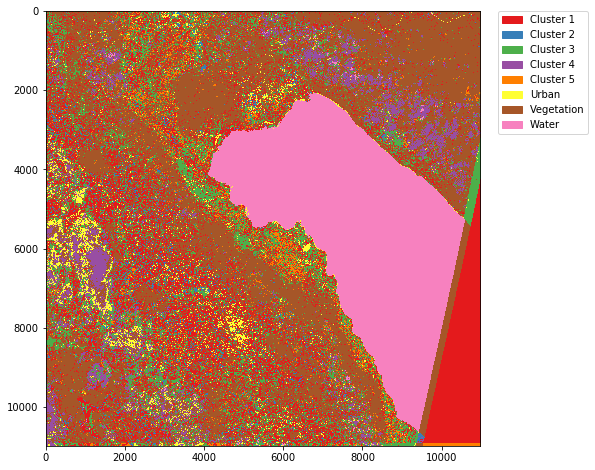

In [31]:
labels = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4',
          4: 'Cluster 5', 5: 'Urban', 6: 'Vegetation', 7: 'Water'}

cols = {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a', 3: '#984ea3',
        4: '#ff7f00', 5: '#ffff33', 6: '#a65628', 7: '#f781bf'}

cmap = colors.ListedColormap(['#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
                              '#ff7f00', '#ffff33', '#a65628', '#f781bf'])

fig = plt.figure(figsize=(10, 8))
im = plt.imshow(pred_mat, cmap=cmap)
patches = [mpatches.Patch(color=cols[i], label=labels[i]) for i in cols]
plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)

In [ ]:
import tensorflow as tf
from keras import backend as kb
import multiprocessing

num_cores = multiprocessing.cpu_count()

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0
    
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
                        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
kb.set_session(session)